##Import Liberaries

In [47]:
!pip install wordcloud

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.stem.porter import PorterStemmer
import string
import re
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')

##Loading Data

In [49]:
df = pd.read_csv('/content/Twitter Sentiments.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


##preprocessing data

In [51]:
## remove the patterns
def remove_patterns(txt,pattern):
  words_found=re.findall(pattern,txt) ##[@user]
  for word in words_found:
    txt =re.sub(word,'',txt)
  return txt


In [52]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [53]:
##remove @user
df['clean_tweet']=np.vectorize(remove_patterns)(df['tweet'],"@[\w]*")


In [54]:
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [55]:
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ",regex=True)


In [56]:
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide society now #motivation


In [57]:
df['clean_tweet']=df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len( w)>3]))

In [58]:
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguide society #motivation


In [59]:
#make tokens
tokenized_tweets=df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweets

0        [when, father, dysfunctional, selfish, drags, ...
1        [thanks, #lyft, credit, cause, they, offer, wh...
2                                  [bihday, your, majesty]
3                         [#model, love, take, with, time]
4                       [factsguide, society, #motivation]
                               ...                        
31957                                        [that, youuu]
31958    [nina, turner, airwaves, trying, wrap, herself...
31959            [listening, songs, monday, morning, work]
31960    [#sikh, #temple, vandalised, #calgary, #wso, c...
31961                                      [thank, follow]
Name: clean_tweet, Length: 31962, dtype: object

In [60]:
#stem the words
stemmer=PorterStemmer()
tokenized_tweets=tokenized_tweets.apply(lambda sentence: [stemmer.stem(word)for word in sentence])
tokenized_tweets.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: clean_tweet, dtype: object

In [61]:
# make the tokinzs in one sentence
for i in range (len(tokenized_tweets)):
  tokenized_tweets[i]=' '.join(tokenized_tweets[i])
df['clean_tweet']=tokenized_tweets
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguid societi #motiv


## Exploratory Data Analysis

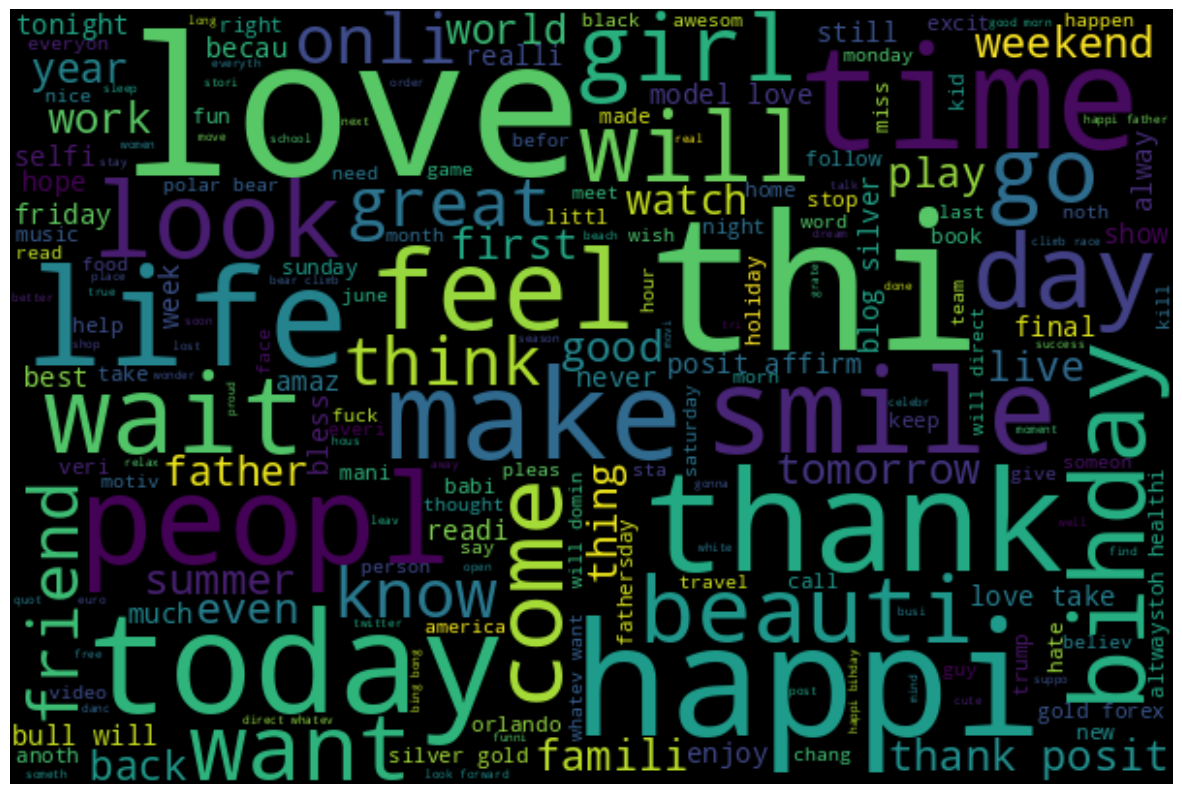

In [62]:
all_words=' '.join([sentence for sentence in df['clean_tweet']])
words=WordCloud(height=400,width=600,random_state=42, max_font_size=100).generate(all_words)
#plot the words
plt.figure(figsize=(15,18))
plt.imshow(words,interpolation='bilinear')
plt.axis('off')
plt.show()


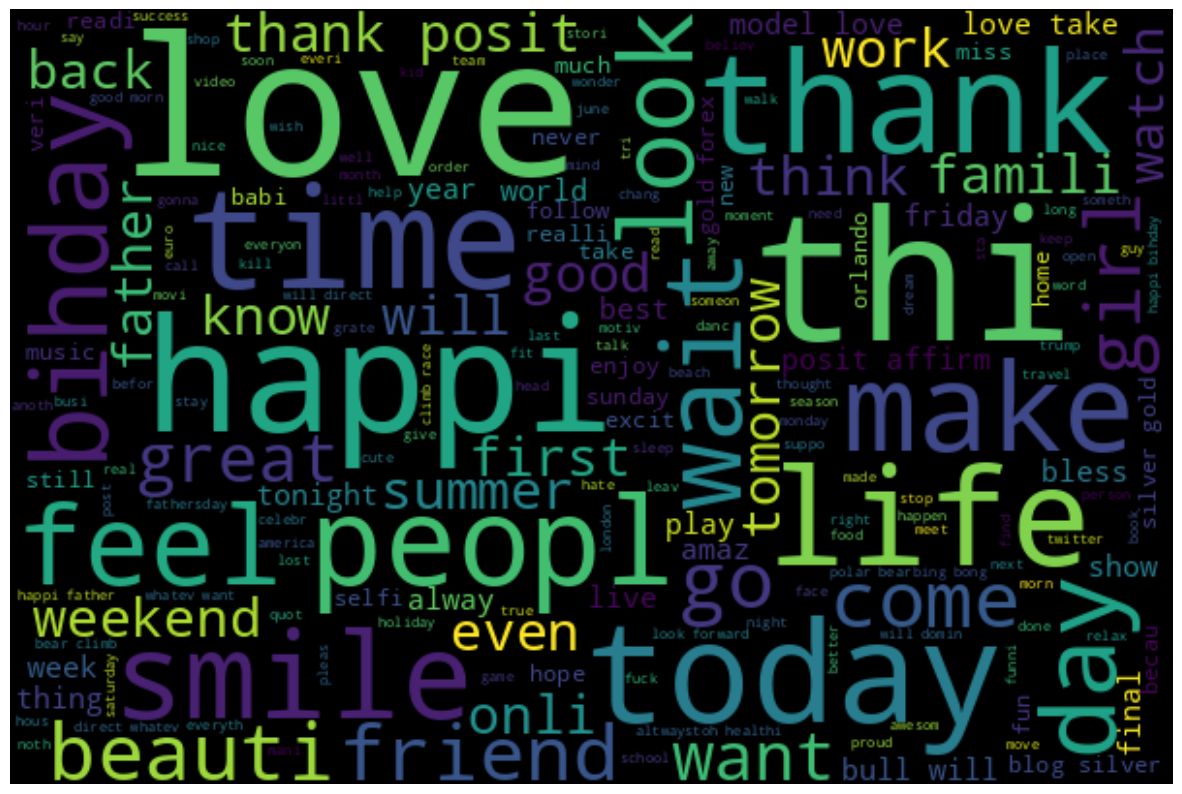

In [63]:
all_words=' '.join([sentence for sentence in df['clean_tweet'] [df['label']==0]])
words=WordCloud(height=400,width=600,random_state=42, max_font_size=100).generate(all_words)
#plot the words
plt.figure(figsize=(15,18))
plt.imshow(words,interpolation='bilinear')
plt.axis('off')
plt.show()


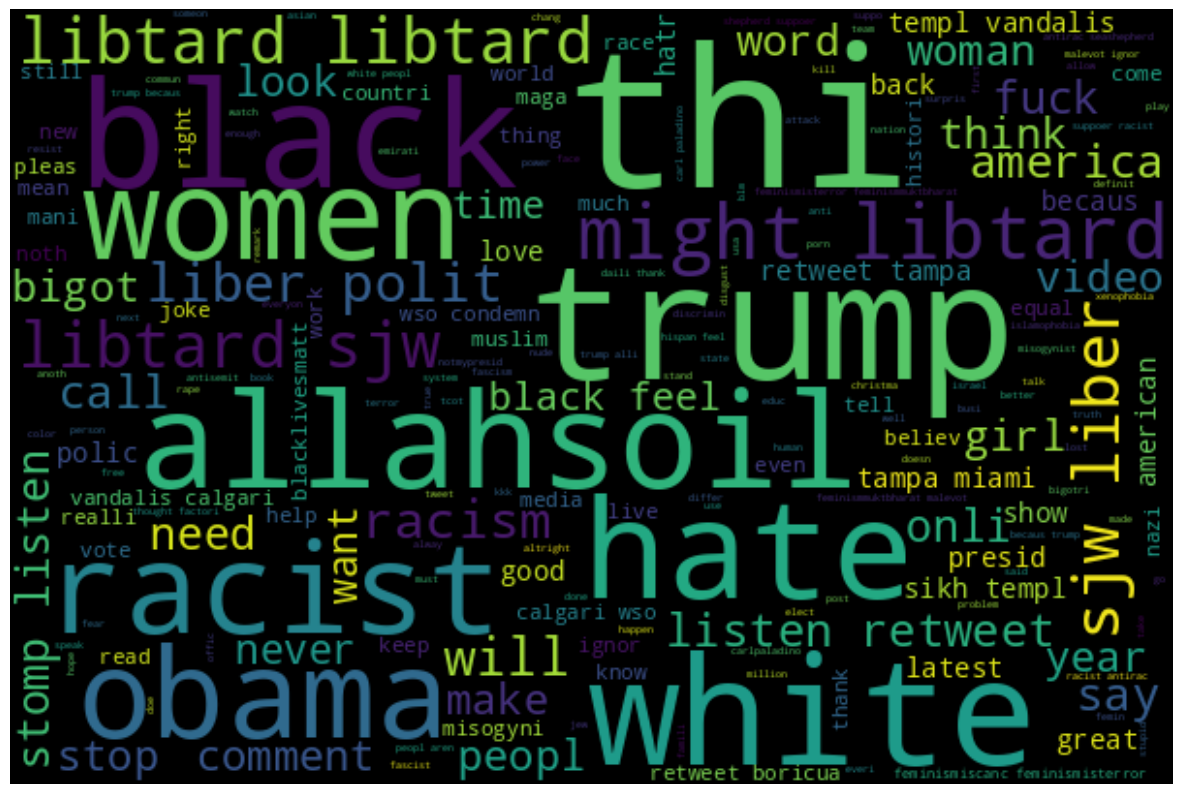

In [64]:
# frequent words visualization for positive words
all_words=' '.join([sentence for sentence in df['clean_tweet'] [df['label']==1]])
words=WordCloud(height=400,width=600,random_state=42, max_font_size=100).generate(all_words)
#plot the words
plt.figure(figsize=(15,18))
plt.imshow(words,interpolation='bilinear')
plt.axis('off')
plt.show()


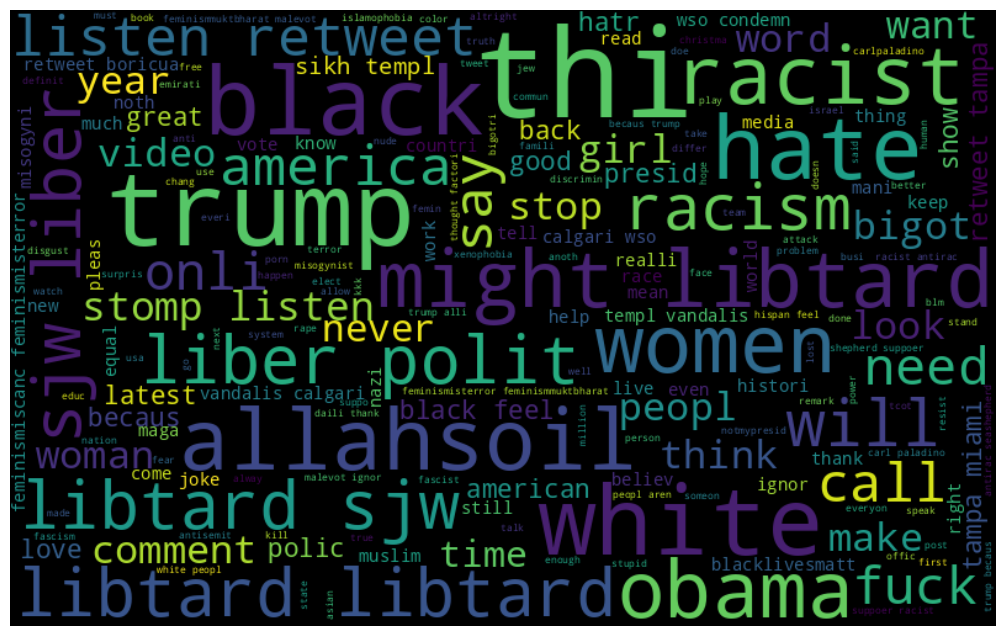

In [65]:
# frequent words visualization for negative words
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==1]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)
# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [66]:
# extract the hashtag
def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags

In [67]:
# extract hashtags from non-racist/sexist tweets
ht_positive = hashtag_extract(df['clean_tweet'][df['label']==0])
# extract hashtags from racist/sexist tweets
ht_negative = hashtag_extract(df['clean_tweet'][df['label']==1])

In [68]:
ht_negative

[['cnn', 'michigan', 'tcot'],
 ['australia',
  'opkillingbay',
  'seashepherd',
  'helpcovedolphin',
  'thecov',
  'helpcovedolphin'],
 [],
 [],
 ['neverump', 'xenophobia'],
 ['love', 'peac'],
 [],
 ['race', 'ident', 'med'],
 ['altright', 'whitesupremaci'],
 ['linguist', 'race', 'power', 'raciolinguist'],
 ['brexit'],
 ['peopl', 'trump', 'republican'],
 ['michelleobama'],
 ['knick', 'golf'],
 ['jewishsupremacist'],
 ['libtard', 'sjw', 'liber', 'polit'],
 ['trash', 'hate'],
 [],
 [],
 ['stereotyp', 'prejudic', 'hope', 'hate', 'conflict'],
 ['pol', 'bluelivesmatt', 'draintheswamp', 'ferguson'],
 [],
 ['antisemit', 'hocoschool', 'columbiamd', 'hocomd'],
 ['nazi', 'hatr', 'bigotri'],
 ['libtard', 'sjw', 'liber', 'polit'],
 ['fyi', 'tcot'],
 ['topoli'],
 ['blacklivesmatt'],
 ['ushistori', 'eugen'],
 ['biher', 'bigotri', 'altright', 'potu', 'theresist'],
 ['crime', 'offic'],
 [],
 ['black', 'retweet', 'tampa', 'miami'],
 ['allahsoil'],
 [],
 ['prais', 'cleveland', 'rnc', 'white', 'tamirric',

In [69]:
# unnest list
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

In [70]:
ht_positive[5]

'motiv'

In [71]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,run,72
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,375


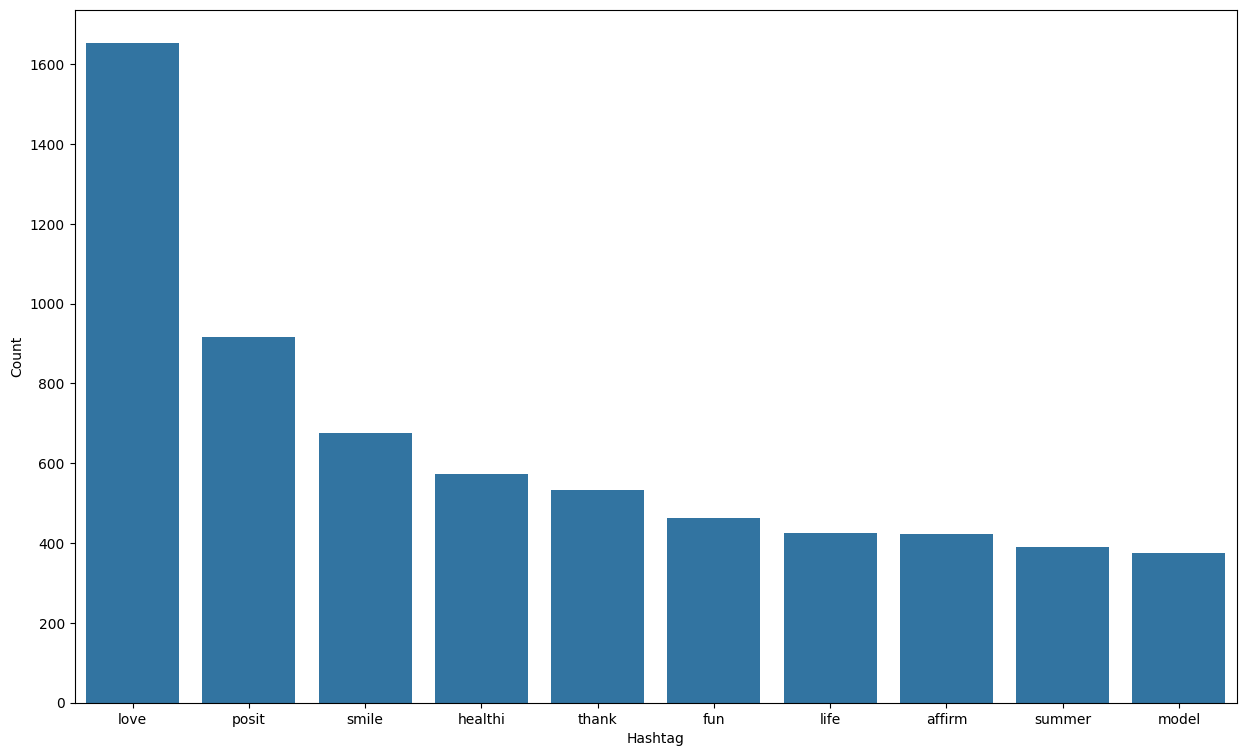

In [72]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [73]:
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5


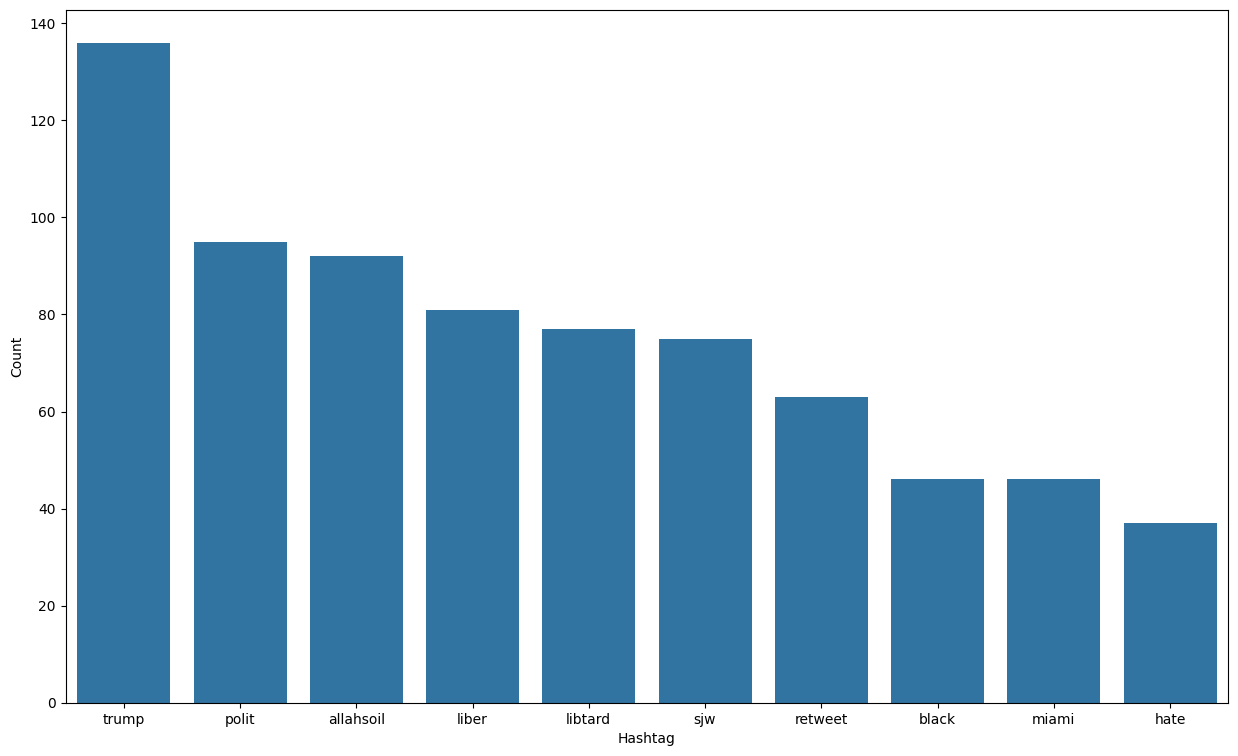

In [74]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

## Input split

In [75]:
# Separate features and target
X = df['clean_tweet']
y = df['label']
# Vectorize the text data
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

In [76]:
# Apply SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_tfidf, y)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

## model training

In [78]:
# training
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Evaluation
print("Accuracy:", accuracy_score(y_test, pred))
print("Classification Report:\n", classification_report(y_test, pred))

Accuracy: 0.9545760430686406
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95      5892
           1       0.93      0.98      0.96      5996

    accuracy                           0.95     11888
   macro avg       0.96      0.95      0.95     11888
weighted avg       0.96      0.95      0.95     11888



In [79]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 0.9856157469717362
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      5892
           1       0.98      0.99      0.99      5996

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



In [80]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9433882907133243
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      5892
           1       0.92      0.98      0.95      5996

    accuracy                           0.94     11888
   macro avg       0.95      0.94      0.94     11888
weighted avg       0.95      0.94      0.94     11888

